Используется датасет https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

Для запуска блокнота, скачайте датасет и поместите его в директорию с блокнотом.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import to_numeric
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Выводим на экран несколько строк таблицы что бы получить примерное представление о данных.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Есть ли записи, содержащие значения NaN или пустые строки?

In [3]:
#заменяем пустые строки на NaN
data = data.replace(r'^\s*$', np.nan, regex=True)
#ищем колонки, которые содержат значения NaN, и подсчитываем количество таких значений
s = data.isna().sum()
s[s > 0]

TotalCharges    11
dtype: int64

Совсем небольшое количество записей содержит значения NaN. Их можно удалить.

In [4]:
data = data.dropna()

Ищем признаки, содержащие строковые данные. Принимаем во внимание, что даже числовые признаки могут содержать строку, если датасет был подготовлен неаккуратно. Например: [2.31, '3.123', 1.23]. Выводим несколько строк таблицы что бы убедится, что найденные данные действительно не числовые.

In [5]:
data.select_dtypes(include=['object']).head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


Результат предыдущей операции содержит колонку TotalCharges, хотя очевидно, что она содержит числовые данные. Конвертируем все значения данной колонки в числовой тип данных.

In [6]:
data['TotalCharges'] = to_numeric(data['TotalCharges'], errors='raise', downcast='float')

#Проверяем, что мы нигде не ошиблись и данные успешно конвертировались. Результаты показывают что значения немного потеряли в точности (вместо 151.65 получилось 151.649994, но это не страшно).
data['TotalCharges'].head()

0      29.850000
1    1889.500000
2     108.150002
3    1840.750000
4     151.649994
Name: TotalCharges, dtype: float32

Прежде чем кодировать категориальные признаки, удалим колонку customerID, т.к. она заведомо бесполезна.

In [7]:
data = data.drop(columns=['customerID'])

Кодируем категориальные признаки.

In [8]:

categorial_data = data.select_dtypes(include=['object'])
for column in categorial_data.columns:
    data[column] = LabelEncoder().fit_transform(data[column])

Найдем признаки которые слабо коррелируют с целевой переменной.

In [9]:
weak_corr_threshold = 0.2

corr_matrix = data.corr()
corr_to_target = corr_matrix['Churn']
for column in corr_to_target.index:
    corr_coefficient = abs(corr_to_target[column])
    if corr_coefficient <= weak_corr_threshold:
       print(column, corr_coefficient)

gender 0.008544643224946347
SeniorCitizen 0.15054105341568125
Partner 0.14998192562005908
Dependents 0.16312843938822022
PhoneService 0.011691398865421603
MultipleLines 0.03804327435621405
InternetService 0.04709716459090005
OnlineBackup 0.19529020856666374
DeviceProtection 0.17788319529016175
StreamingTV 0.036302721512460306
StreamingMovies 0.03880174840533724
PaperlessBilling 0.19145432108004623
PaymentMethod 0.10785201511046885
MonthlyCharges 0.192858218470079
TotalCharges 0.19948408409394872


Большинство признаков очень слабо коррелируют с целевой переменной. Удалим их.
Признаки DeviceProtection, PaperlessBilling, MonthlyCharges и TotalCharges также не очень сильно коррелируют с целевой переменной, однако оставим их.

ПРИМЕЧАНИЕ: забегая вперед, модель показывает лучший результат если оставить только три признака: OnlineSecurity, TechSupport и Contract.
Однако, в этом случае классификатор будет работать лучше всего с параметрами по-умолчанию и качество будет одинаковым для всех классификаторов. Это нам не подходит т.к. в текущем задании необходимо произвести настройку гиперпараметров и сравнить классификаторы.

In [10]:
data = data.drop(columns=['gender', 'SeniorCitizen', 'Partner',
                          'Dependents', 'PhoneService', 'MultipleLines',
                          'InternetService', 'OnlineBackup',
                          'StreamingTV', 'StreamingMovies'])

Ищем признаки, которые сильно коррелируют друг с другом.

In [11]:
strong_corr_threshold = 0.5

corr_matrix = data.corr()
high_corr_matrix = corr_matrix[abs(corr_matrix) >= strong_corr_threshold]
strong_corr_features = high_corr_matrix.notna().sum()
strong_corr_features[strong_corr_features > 1]

tenure            3
Contract          2
MonthlyCharges    2
TotalCharges      3
dtype: int64

Следующие признаки сильно коррелируют другими параметрами: tenure, Contract, MonthlyCharges, TotalCharges. Построим тепловую карту и посмотрим, можно ли удалить некоторые из них.

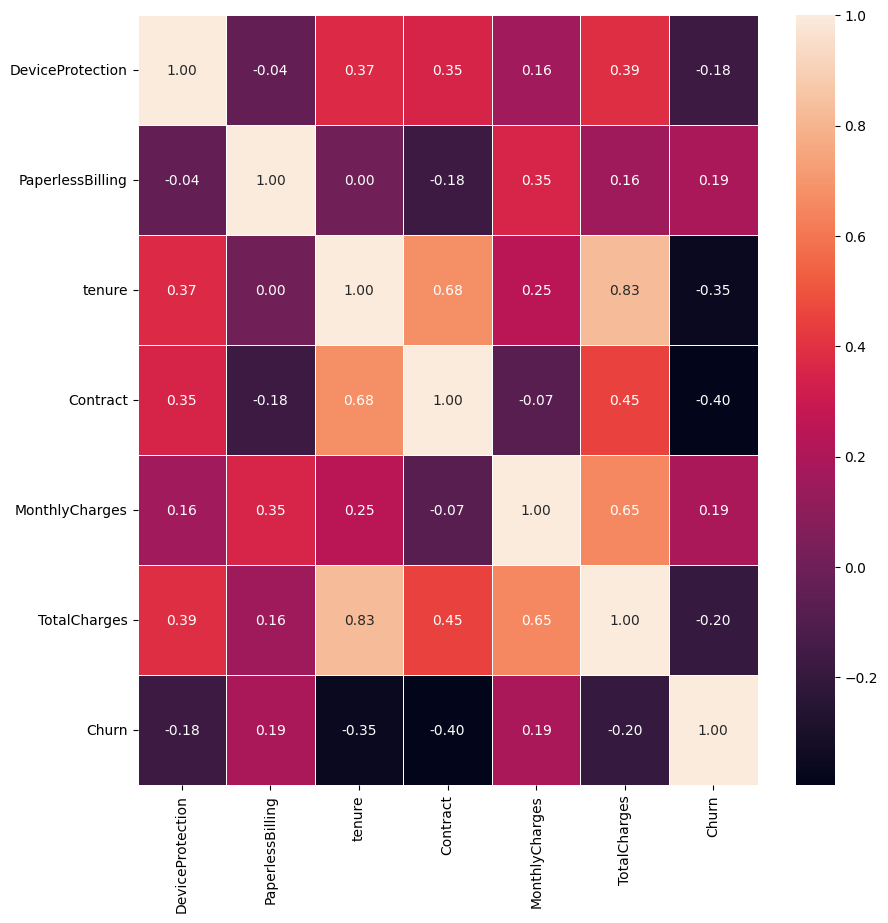

In [12]:
corr_matrix = data[['DeviceProtection', 'PaperlessBilling', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cbar=True, linewidths=.5, fmt= '.2f')
plt.show()

Tenure сильно коррелирует со многими признаками. Было бы разумно удалить этот признак. Однако опытным путем было установлено, что лучше удалить PaperlessBilling.

In [13]:
data = data.drop(columns=['PaperlessBilling'])

Разбиваем данные на train и test.

In [14]:
x = data.drop(columns=['Churn'])
y = data['Churn'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

Сравним разные реализации градиентного бустинга. Пока что используем настройки по-умолчанию.

Реализация sklearn.

In [15]:
gbm = GradientBoostingClassifier(random_state=123).fit(x_train, y_train)
roc_auc_score(y_test, gbm.predict(x_test))

0.7070874739835253

XGBoost

In [16]:
xgbc = XGBClassifier().fit(x_train, y_train)
roc_auc_score(y_test, xgbc.predict(x_test))

0.7155080174713452

CatBoost

In [17]:
cbm = CatBoostClassifier(random_seed=123).fit(x_train, y_train, verbose=False)
roc_auc_score(y_test, cbm.predict(x_test))

0.7071461026588105

LightGBM

In [18]:
lgbm = LGBMClassifier(random_state=123, verbose=0).fit(x_train, y_train)
roc_auc_score(y_test, lgbm.predict(x_test))

0.7129393486354175

С настройками по-умолчанию лидирует реализация XGBoost. Хуже всех показали себя стандартная реализация от sklearn и, как ни странно, CatBoost.

Теперь попробуем подобрать оптимальные параметры модели при помощи кросс-валидации.

ПРИМЕЧАНИЕ: параметры подбирались итеративно и много раз менялись. По итогу в блокноте остались только лучшие параметры.
Поэтому ниже можно встретить следующий код:

param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.065],
    'subsample': [0.9],
    'max_depth': [2],
}

Это лучшие параметры, которые остались после подбора.

In [19]:
gbm = GradientBoostingClassifier(random_state=123, 
                                 max_features='sqrt',
                                 min_samples_split=2,
                                 min_samples_leaf=1)
param_grid = {
    #'n_estimators': [200, 205],
    #'learning_rate': [0.63, 0.065, 0.67],
    #'subsample': [0.9, 0.93, 0.95],
    #'max_depth': [2],
    'n_estimators': [200],
    'learning_rate': [0.065],
    'subsample': [0.9],
    'max_depth': [2],
}
grid_search_cmb = GridSearchCV(gbm, param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search_cmb.fit(x_train, y_train)

print('Best score: ', grid_search_cmb.best_score_)
print('Best params: ', grid_search_cmb.best_params_)

print(roc_auc_score(y_test, grid_search_cmb.best_estimator_.predict(x_test)))

Best score:  0.8421669674854215
Best params:  {'learning_rate': 0.065, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}
0.7102351009878931


In [20]:
xgbc = XGBClassifier(random_state=123)

param_grid = {
    'n_estimators': [200], #[190, 200, 210],
    'learning_rate': [0.065], #[0.6, 0.065, 0.7],
    'subsample': [0.9], #[0.85, 0.9, 0.95],
    'max_depth': [2], #[2,3],
}
grid_search_cmb = GridSearchCV(xgbc, param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search_cmb.fit(x_train, y_train)

print('Best score: ', grid_search_cmb.best_score_)
print('Best params: ', grid_search_cmb.best_params_)

print(roc_auc_score(y_test, grid_search_cmb.best_estimator_.predict(x_test)))

Best score:  0.8411679970027789
Best params:  {'learning_rate': 0.065, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}
0.7148887520886466


CatBoost

In [21]:

cbm = CatBoostClassifier(random_seed=123,
                         verbose=False)

param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.065],
    'subsample': [0.9],
    'max_depth': [2],
}
grid_search_cmb = GridSearchCV(cbm, param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search_cmb.fit(x_train, y_train)

print('Best score: ', grid_search_cmb.best_score_)
print('Best params: ', grid_search_cmb.best_params_)

print(roc_auc_score(y_test, grid_search_cmb.best_estimator_.predict(x_test)))

Best score:  0.8411293853790072
Best params:  {'learning_rate': 0.065, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}
0.7190403951572715


In [22]:
lgbm = LGBMClassifier(random_seed=123)

param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.065],
    'subsample': [0.9],
    'max_depth': [2]
}
grid_search_cmb = GridSearchCV(cbm, param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search_cmb.fit(x_train, y_train)

print('Best score: ', grid_search_cmb.best_score_)
print('Best params: ', grid_search_cmb.best_params_)

print(roc_auc_score(y_test, grid_search_cmb.best_estimator_.predict(x_test)))

Best score:  0.8411293853790072
Best params:  {'learning_rate': 0.065, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}
0.7190403951572715


Теперь победили CatBoost и LightGBM с результатом ROC AUC 0.719.

Выводы:
- Все алгоритмы неплохо работают, но CatBoost и LightGBM показали немного лучший результат.
- Результат все еще не очень хороший. Видимо EDA был проведет недостаточно качественно.
Можно получить лучший результат удалив все признаки, кроме OnlineSecurity, TechSupport и Contract.
В этом случае ROC AUC улучшится и составит 0.7346 для всех классификаторов. Однако в этом случае подобрать лучшие значения, чем с параметрами по-умолчанию, не получилось.